In [55]:
using Lux#, Optimisers, Random, Statistics, Zygote
using NPZ
using JLD2
using CairoMakie
using PyCall

np = pyimport("numpy")

PyObject <module 'numpy' from '/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/__init__.py'>

In [56]:
nk = 100
nz = 20
nc = 2000
ncv = 1000

cicli = 20
epoche = 20000
div = 5

5

In [57]:
input = npzread("../files/train_in_emul_" * string(nc) * ".npy")
output = npzread("../files/train_out_emul_" * string(nc) * ".npy")
output = output'

x = input
y = output

2000×2000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0222209   0.0217774   0.0278083   …  0.0265592   0.0249026   0.0246019
 0.0166464   0.0164317   0.0212954      0.0202211   0.0187964   0.0186478
 0.0126009   0.0125271   0.0163799      0.0154822   0.0142932   0.0142396
 0.00972353  0.00973396  0.0127809      0.0120375   0.0110539   0.0110578
 0.00766538  0.00772504  0.0101535      0.00953625  0.00872009  0.00875785
 0.00616798  0.00625557  0.00821454  …  0.00769778  0.00701477  0.00707186
 0.00505575  0.00515827  0.0067597      0.00632268  0.0057451   0.00581258
 0.0042121   0.00432162  0.00564814     0.00527466  0.004781    0.00485338
 0.00355947  0.00367107  0.00478359     0.0044612   0.00403499  0.00410887
 0.00304545  0.00315614  0.00409986     0.00381901  0.0034476   0.00352091
 0.00263402  0.00274198  0.00355084  …  0.00330413  0.00297776  0.00304924
 0.00229994  0.00240407  0.00310387     0.00288553  0.00259657  0.00266548
 0.00202514  0.00212484  0.00273546     0.0025

In [58]:
# standardizzazione del trainig dataset (feature - min(features))/(max(features) - min(features))
min_in = minimum(x, dims=2)
max_in = maximum(x, dims=2)

min_out = minimum(y, dims=2)
max_out = maximum(y, dims=2)

x = (x .- min_in) ./ (max_in .- min_in)
y = (y .- min_out) ./ (max_out .- min_out)

2000×2000 Matrix{Float64}:
 0.233446  0.195981  0.705448  0.274313  …  0.599925  0.459986  0.434584
 0.219371  0.197005  0.703706  0.255269     0.591783  0.443364  0.427876
 0.207344  0.197684  0.702069  0.239057     0.584553  0.428898  0.421877
 0.196869  0.19859   0.700988  0.224884     0.578414  0.416234  0.416871
 0.187506  0.199807  0.700462  0.212142     0.573203  0.404944  0.412728
 0.17894   0.201254  0.700348  0.20043   …  0.568692  0.394678  0.409224
 0.170811  0.202642  0.69984   0.189326     0.564157  0.384834  0.405787
 0.163123  0.204008  0.699253  0.17883      0.559817  0.375513  0.402536
 0.155879  0.205379  0.6988    0.168939     0.555817  0.36678   0.399551
 0.14904   0.206716  0.698431  0.159606     0.552099  0.358576  0.396776
 0.142583  0.207996  0.698116  0.150804  …  0.548628  0.350863  0.394176
 0.136495  0.209203  0.697833  0.142516     0.545379  0.343617  0.39173
 0.130768  0.210326  0.697573  0.134732     0.542337  0.336821  0.389423
 ⋮                       

In [59]:
# carico lo stato allenato della rete

tstate = JLD2.load("../models/nn+sr_$(cicli)-$(epoche)_$(div).jld2", "tstate")

# importo validation dataset

valid_in = npzread("../files/val_in_emul_" * string(ncv) * ".npy")
valid_in = (valid_in .- minimum(valid_in, dims=2)) ./ (maximum(valid_in, dims=2) .- minimum(valid_in, dims=2))
valid_out = npzread("../files/val_out_emul_" * string(ncv) * ".npy")
val_out = valid_out'

2000×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0288784   0.0262525   0.0223673   …  0.021419    0.0232779   0.0240215
 0.0220906   0.019975    0.016827       0.0161185   0.017704    0.0181075
 0.0169625   0.0152875   0.0127857      0.0122632   0.0135773   0.013763
 0.0132065   0.0118834   0.00989943     0.00951391  0.0105959   0.010646
 0.0104655   0.00941306  0.00782783     0.00754106  0.00843619  0.00840355
 0.00844493  0.00759809  0.00631615  …  0.00610044  0.00684829  0.00676603
 0.00693122  0.00624086  0.00519031     0.00502614  0.005658    0.00554689
 0.00577683  0.00520658  0.00433426     0.00420793  0.00474775  0.00462085
 0.00488078  0.00440383  0.0036705      0.00357231  0.0040383   0.00390389
 0.00417365  0.00377008  0.00314659     0.00306959  0.00347564  0.00333896
 0.00360707  0.00326196  0.00272638  …  0.00266554  0.00302234  0.00288673
 0.00314681  0.00284882  0.00238449     0.0023361   0.00265196  0.00251951
 0.00276824  0.00250868  0.00210274     0.002064

In [60]:
# predizione con training dataset
dev_cpu = cpu_device()
pred_train_iniz = dev_cpu(Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_train_st = (pred_train_iniz .- minimum(pred_train_iniz, dims=2)) ./ (maximum(pred_train_iniz, dims=2) .- minimum(pred_train_iniz, dims=2))

# de-standardizzo la predizione standardizzata
pred_train_st = pred_train_st .* (max_out - min_out) .+ min_out

# de-standrdizzo la predizione iniziale
pred_train = pred_train_iniz .* (max_out - min_out) .+ min_out

2000×2000 Matrix{Float64}:
 0.0222252   0.0217808   0.0278047   …  0.0265594   0.0249043   0.0246025
 0.0166479   0.016433    0.0212926      0.0202222   0.0187953   0.0186475
 0.0126022   0.0125276   0.016378       0.0154836   0.0142933   0.0142397
 0.0097244   0.00973513  0.0127793      0.0120389   0.0110535   0.0110576
 0.00766626  0.00772575  0.0101522      0.00953733  0.00872028  0.00875777
 0.00616824  0.0062557   0.00821378  …  0.00769825  0.00701455  0.00707186
 0.00505618  0.0051584   0.00675891     0.00632316  0.00574457  0.00581239
 0.00421272  0.00432149  0.00564755     0.00527524  0.00478103  0.00485337
 0.00355988  0.00367113  0.00478311     0.00446183  0.00403488  0.00410882
 0.00304582  0.00315594  0.00409954     0.00381939  0.00344771  0.00352091
 0.00263408  0.00274196  0.00355061  …  0.00330469  0.00297789  0.00304919
 0.00230029  0.00240416  0.00310366     0.00288586  0.00259676  0.00266549
 0.00202531  0.00212482  0.00273526     0.00254131  0.00228324  0.0023492
 ⋮ 

In [61]:
# predizione con validation dataset
pred_val_iniz = dev_cpu(Lux.apply(tstate.model, valid_in, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_val_st = (pred_val_iniz .- minimum(pred_val_iniz, dims=2)) ./ (maximum(pred_val_iniz, dims=2) .- minimum(pred_val_iniz, dims=2))

# de-standardizzo la predizione standardizzata
pred_val_st = pred_val_st .* (max_out - min_out) .+ min_out

# de-standrdizzo la predizione iniziale
pred_val = pred_val_iniz .* (max_out - min_out) .+ min_out

2000×1000 Matrix{Float64}:
 0.0288786   0.0262565   0.0223686   …  0.0214179   0.0232809   0.0240266
 0.0220923   0.0199772   0.0168278      0.0161179   0.0177078   0.0181109
 0.016964    0.0152897   0.012788       0.0122612   0.0135797   0.0137655
 0.0132072   0.0118856   0.00990047     0.0095132   0.0105981   0.0106481
 0.0104658   0.00941526  0.00782905     0.00753997  0.00843794  0.00840532
 0.00844607  0.00759924  0.00631694  …  0.0061      0.00684906  0.00676702
 0.00693211  0.00624169  0.00519076     0.00502579  0.00565907  0.00554787
 0.00577747  0.00520733  0.00433469     0.00420764  0.00474854  0.00462185
 0.00488137  0.0044047   0.00367101     0.00357202  0.00403908  0.00390467
 0.00417422  0.00377059  0.00314704     0.00306934  0.00347604  0.00333956
 0.00360753  0.00326249  0.00272682  …  0.00266536  0.00302294  0.00288742
 0.00314714  0.00284936  0.00238478     0.002336    0.00265233  0.00252011
 0.00276873  0.00250908  0.00210307     0.00206384  0.0023461   0.00221804
 ⋮

In [62]:
print(size(pred_val))

(2000, 1000)

In [63]:
# salvo i dati predetti in un array di numpy
np.save("../files/pred_nn+sr_val_" *string(ncv), pred_val)
np.save("../files/pred_nn+sr_" *string(nc), pred_train)

## Plot residui rapporto

In [64]:
# preparo il plot delle differenze percentuali con il training dataset

diffk = zeros(Float64, nc*nz, nk)
diffz = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk[:,i] = reshape(100*abs.(1 .- pred_train[start:stop,:] ./ output[start:stop,:]), nc*nz, 1)
end
diffk = sort(diffk, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz[:,i] = reshape(100*abs.(1 .- pred_train[index,:] ./ output[index,:]), nc*nk, 1)
end
diffz = sort(diffz, dims=1)


200000×20 Matrix{Float64}:
 5.47835e-7  2.44843e-7  1.57814e-8  …  2.51491e-7  2.50809e-7  1.19375e-7
 6.50035e-7  2.44943e-7  1.60059e-7     3.43846e-7  4.75612e-7  1.39531e-7
 7.11587e-7  2.58145e-7  2.18304e-7     3.83894e-7  4.79054e-7  2.0027e-7
 8.79903e-7  2.64109e-7  4.42591e-7     4.48455e-7  6.99927e-7  3.64459e-7
 1.25312e-6  4.615e-7    8.43987e-7     6.38798e-7  8.96531e-7  4.42383e-7
 1.29604e-6  4.67943e-7  1.03938e-6  …  6.7574e-7   1.10329e-6  5.96121e-7
 1.29713e-6  5.48273e-7  1.0509e-6      6.91883e-7  1.21357e-6  8.43511e-7
 1.35391e-6  5.56937e-7  1.06377e-6     8.71574e-7  1.47518e-6  9.43623e-7
 1.41613e-6  6.85447e-7  1.08479e-6     1.08628e-6  1.57961e-6  9.46641e-7
 1.46488e-6  7.58528e-7  1.14832e-6     1.10404e-6  1.70261e-6  9.61036e-7
 1.47832e-6  8.65659e-7  1.27299e-6  …  1.23148e-6  1.9039e-6   1.08375e-6
 1.65887e-6  1.17358e-6  1.58939e-6     1.26047e-6  1.90456e-6  1.40264e-6
 1.86706e-6  1.23923e-6  1.5949e-6      1.28497e-6  1.9171e-6   1.43084e-6

In [65]:
# preparo il plot delle differenze percentuali con il validation dataset

diffk_v = zeros(Float64, ncv*nz, nk)
diffz_v = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk_v[:,i] = reshape(100*abs.(1 .- pred_val[start:stop,:] ./ val_out[start:stop,:]), ncv*nz, 1)
end
diffk_v = sort(diffk_v, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz_v[:,i] = reshape(100*abs.(1 .- pred_val[index,:] ./ val_out[index,:]), ncv*nk, 1)
end
diffz_v = sort(diffz_v, dims=1)

100000×20 Matrix{Float64}:
 3.02403e-7  9.26872e-8  1.53666e-7  …  2.67755e-8  4.23477e-7  8.96635e-7
 5.99658e-7  2.26428e-7  4.40065e-7     4.34014e-7  4.59328e-7  9.92928e-7
 1.12119e-6  1.02587e-6  5.0842e-7      9.00989e-7  6.13028e-7  2.07607e-6
 1.22661e-6  2.22068e-6  5.78865e-7     9.99653e-7  6.62766e-7  4.35948e-6
 1.40606e-6  3.53333e-6  6.13792e-7     1.88239e-6  1.01303e-6  4.97151e-6
 2.48164e-6  3.75056e-6  6.94263e-7  …  2.38744e-6  1.29469e-6  5.07101e-6
 2.49654e-6  4.28599e-6  1.01478e-6     3.24421e-6  1.40557e-6  5.16124e-6
 2.84298e-6  4.48213e-6  1.14375e-6     3.38449e-6  1.61988e-6  5.17544e-6
 3.60769e-6  4.62516e-6  1.33401e-6     3.50822e-6  2.01948e-6  5.35689e-6
 4.9242e-6   4.76965e-6  1.99864e-6     4.45875e-6  2.66167e-6  5.797e-6
 5.40168e-6  5.02149e-6  2.26476e-6  …  5.08051e-6  4.59221e-6  5.81003e-6
 5.73458e-6  5.07094e-6  2.59486e-6     5.47084e-6  5.22577e-6  6.23229e-6
 6.03093e-6  6.35536e-6  2.9464e-6      5.65103e-6  6.22641e-6  6.23513e-6


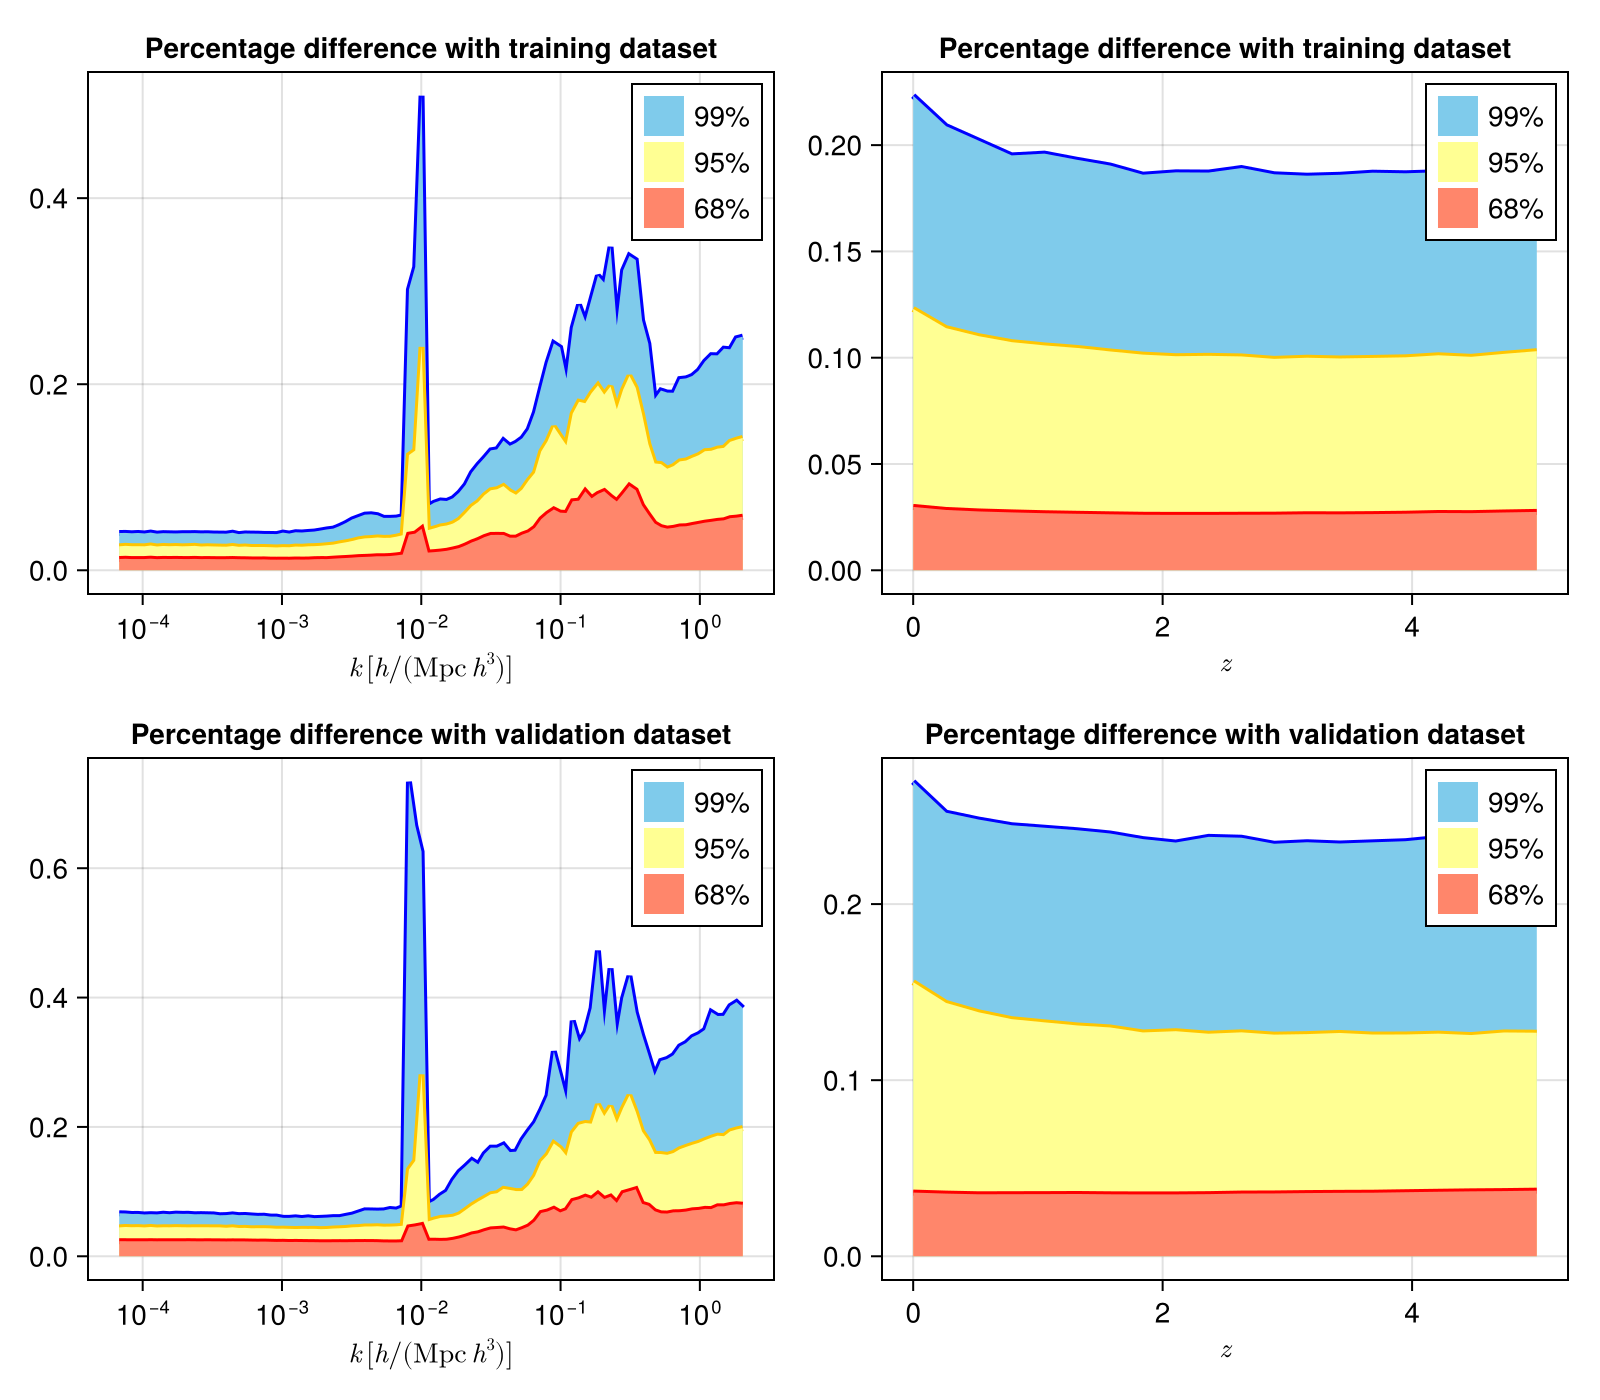

In [66]:
fig = Figure(size = (800, 700))

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

xax = [[kk,kk] [zz,zz]]
diffs = [[diffk,diffk_v] [diffz,diffz_v]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert(Int, (size(diffs[i,j])[1]/100)*99)
        l99 = lines!(ax, xax[i,j], diffs[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert(Int, (size(diffs[i,j])[1]/100)*95)
        l95 = lines!(ax, xax[i,j], diffs[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs[i,j][ind95,:], color="#FFFF93")

        ind68 = convert(Int, (size(diffs[i,j])[1]/100)*68)
        l68 = lines!(ax, xax[i,j], diffs[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Percentage difference with training dataset"
        else
            ax.title = "Percentage difference with validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(\mathrm{Mpc} \, h^3)]"
            ax.xscale = log10
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_nn+sr_$(cicli)-$(epoche)_$(div).pdf", fig)
return fig


In [67]:
# best validation loss: 3.3552296894440923e-7

## Plot residui $P(k,z)$

In [68]:
# compongo il pkz dal training dataset

tf2 = npzread("../files/train_tf2_emul_" * string(nc) * ".npy")'
mu2 = np.reshape(npzread("../files/train_mu2_emul_" * string(nc) * ".npy"), [nc,nk*nz])'
pkz_class = np.reshape(npzread("../files/train_pkz_emul_" * string(nc) * ".npy"), [nc,nk*nz])'
prim = npzread("../files/train_prim_emul_" * string(nc) * ".npy")'

pkz_prim = np.zeros([nk,nz,nc])
transfer2 = np.zeros([nk,nz,nc])
for i in 1:nz
    pkz_prim[:,i,:] = prim
    transfer2[:,i,:] = tf2
end

pkz_prim = np.reshape(pkz_prim, [nk*nz,nc])
transfer2 = np.reshape(transfer2, [nk*nz,nc])

pkz_pred_train = pred_train .* pkz_prim .* transfer2 .* mu2
println(size(pkz_pred_train))

(2000, 2000)


In [69]:
# compongo il pkz dal validation dataset

tf2_v =  npzread("../files/val_tf2_emul_" * string(ncv) * ".npy")'
mu2_v = np.reshape(npzread("../files/val_mu2_emul_" * string(ncv) * ".npy"), [ncv,nk*nz])'
pkz_class_v = np.reshape(npzread("../files/val_pkz_emul_" * string(ncv) * ".npy"), [ncv,nk*nz])'
prim_v = npzread("../files/val_prim_emul_" * string(ncv) * ".npy")'

pkz_prim_v = np.zeros([nk,nz,ncv])
transfer2_v = np.zeros([nk,nz,ncv])
for i in 1:nz
    pkz_prim_v[:,i,:] = prim_v
    transfer2_v[:,i,:] = tf2_v
end

pkz_prim_v = np.reshape(pkz_prim_v, [nk*nz,ncv])
transfer2_v = np.reshape(transfer2_v, [nk*nz,ncv])

pkz_pred_val = pred_val .* pkz_prim_v .* transfer2_v .* mu2_v
println(size(pkz_pred_val))

(2000, 1000)


In [70]:
# preparo il plot delle differenze percentuali con il training dataset

difk = zeros(Float64, nc*nz, nk)
difz = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    difk[:,i] = reshape(100*abs.(1 .- pkz_pred_train[start:stop,:] ./ pkz_class[start:stop,:]), nc*nz, 1)
end
difk = sort(difk, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    difz[:,i] = reshape(100*abs.(1 .- pkz_pred_train[index,:] ./ pkz_class[index,:]), nc*nk, 1)
end
difz = sort(difz, dims=1)


200000×20 Matrix{Float64}:
 5.47835e-7  2.44843e-7  1.57814e-8  …  2.51491e-7  2.50809e-7  1.19375e-7
 6.50035e-7  2.44943e-7  1.60059e-7     3.43846e-7  4.75612e-7  1.39531e-7
 7.11587e-7  2.58145e-7  2.18304e-7     3.83894e-7  4.79054e-7  2.0027e-7
 8.79903e-7  2.64109e-7  4.42591e-7     4.48455e-7  6.99927e-7  3.64459e-7
 1.25312e-6  4.615e-7    8.43987e-7     6.38798e-7  8.96531e-7  4.42383e-7
 1.29604e-6  4.67943e-7  1.03938e-6  …  6.7574e-7   1.10329e-6  5.96121e-7
 1.29713e-6  5.48273e-7  1.0509e-6      6.91883e-7  1.21357e-6  8.43511e-7
 1.35391e-6  5.56937e-7  1.06377e-6     8.71574e-7  1.47518e-6  9.43623e-7
 1.41613e-6  6.85447e-7  1.08479e-6     1.08628e-6  1.57961e-6  9.46641e-7
 1.46488e-6  7.58528e-7  1.14832e-6     1.10404e-6  1.70261e-6  9.61036e-7
 1.47832e-6  8.65659e-7  1.27299e-6  …  1.23148e-6  1.9039e-6   1.08375e-6
 1.65887e-6  1.17358e-6  1.58939e-6     1.26047e-6  1.90456e-6  1.40264e-6
 1.86706e-6  1.23923e-6  1.5949e-6      1.28497e-6  1.9171e-6   1.43084e-6

In [71]:
# preparo il plot delle differenze percentuali con il validation dataset

difk_v = zeros(Float64, ncv*nz, nk)
difz_v = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    difk_v[:,i] = reshape(100*abs.(1 .- pkz_pred_val[start:stop,:] ./ pkz_class_v[start:stop,:]), ncv*nz, 1)
end
difk_v = sort(difk_v, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    difz_v[:,i] = reshape(100*abs.(1 .- pkz_pred_val[index,:] ./ pkz_class_v[index,:]), ncv*nk, 1)
end
difz_v = sort(difz_v, dims=1)

100000×20 Matrix{Float64}:
 3.02403e-7  9.26872e-8  1.53666e-7  …  2.67755e-8  4.23477e-7  8.96635e-7
 5.99658e-7  2.26428e-7  4.40065e-7     4.34014e-7  4.59328e-7  9.92928e-7
 1.12119e-6  1.02587e-6  5.0842e-7      9.00989e-7  6.13028e-7  2.07607e-6
 1.22661e-6  2.22068e-6  5.78865e-7     9.99653e-7  6.62766e-7  4.35948e-6
 1.40606e-6  3.53333e-6  6.13792e-7     1.88239e-6  1.01303e-6  4.97151e-6
 2.48164e-6  3.75056e-6  6.94263e-7  …  2.38744e-6  1.29469e-6  5.07101e-6
 2.49654e-6  4.28599e-6  1.01478e-6     3.24421e-6  1.40557e-6  5.16124e-6
 2.84298e-6  4.48213e-6  1.14375e-6     3.38449e-6  1.61988e-6  5.17544e-6
 3.60769e-6  4.62516e-6  1.33401e-6     3.50822e-6  2.01948e-6  5.35689e-6
 4.9242e-6   4.76965e-6  1.99864e-6     4.45875e-6  2.66167e-6  5.797e-6
 5.40168e-6  5.02149e-6  2.26476e-6  …  5.08051e-6  4.59221e-6  5.81003e-6
 5.73458e-6  5.07094e-6  2.59486e-6     5.47084e-6  5.22577e-6  6.23229e-6
 6.03093e-6  6.35536e-6  2.9464e-6      5.65103e-6  6.22641e-6  6.23513e-6


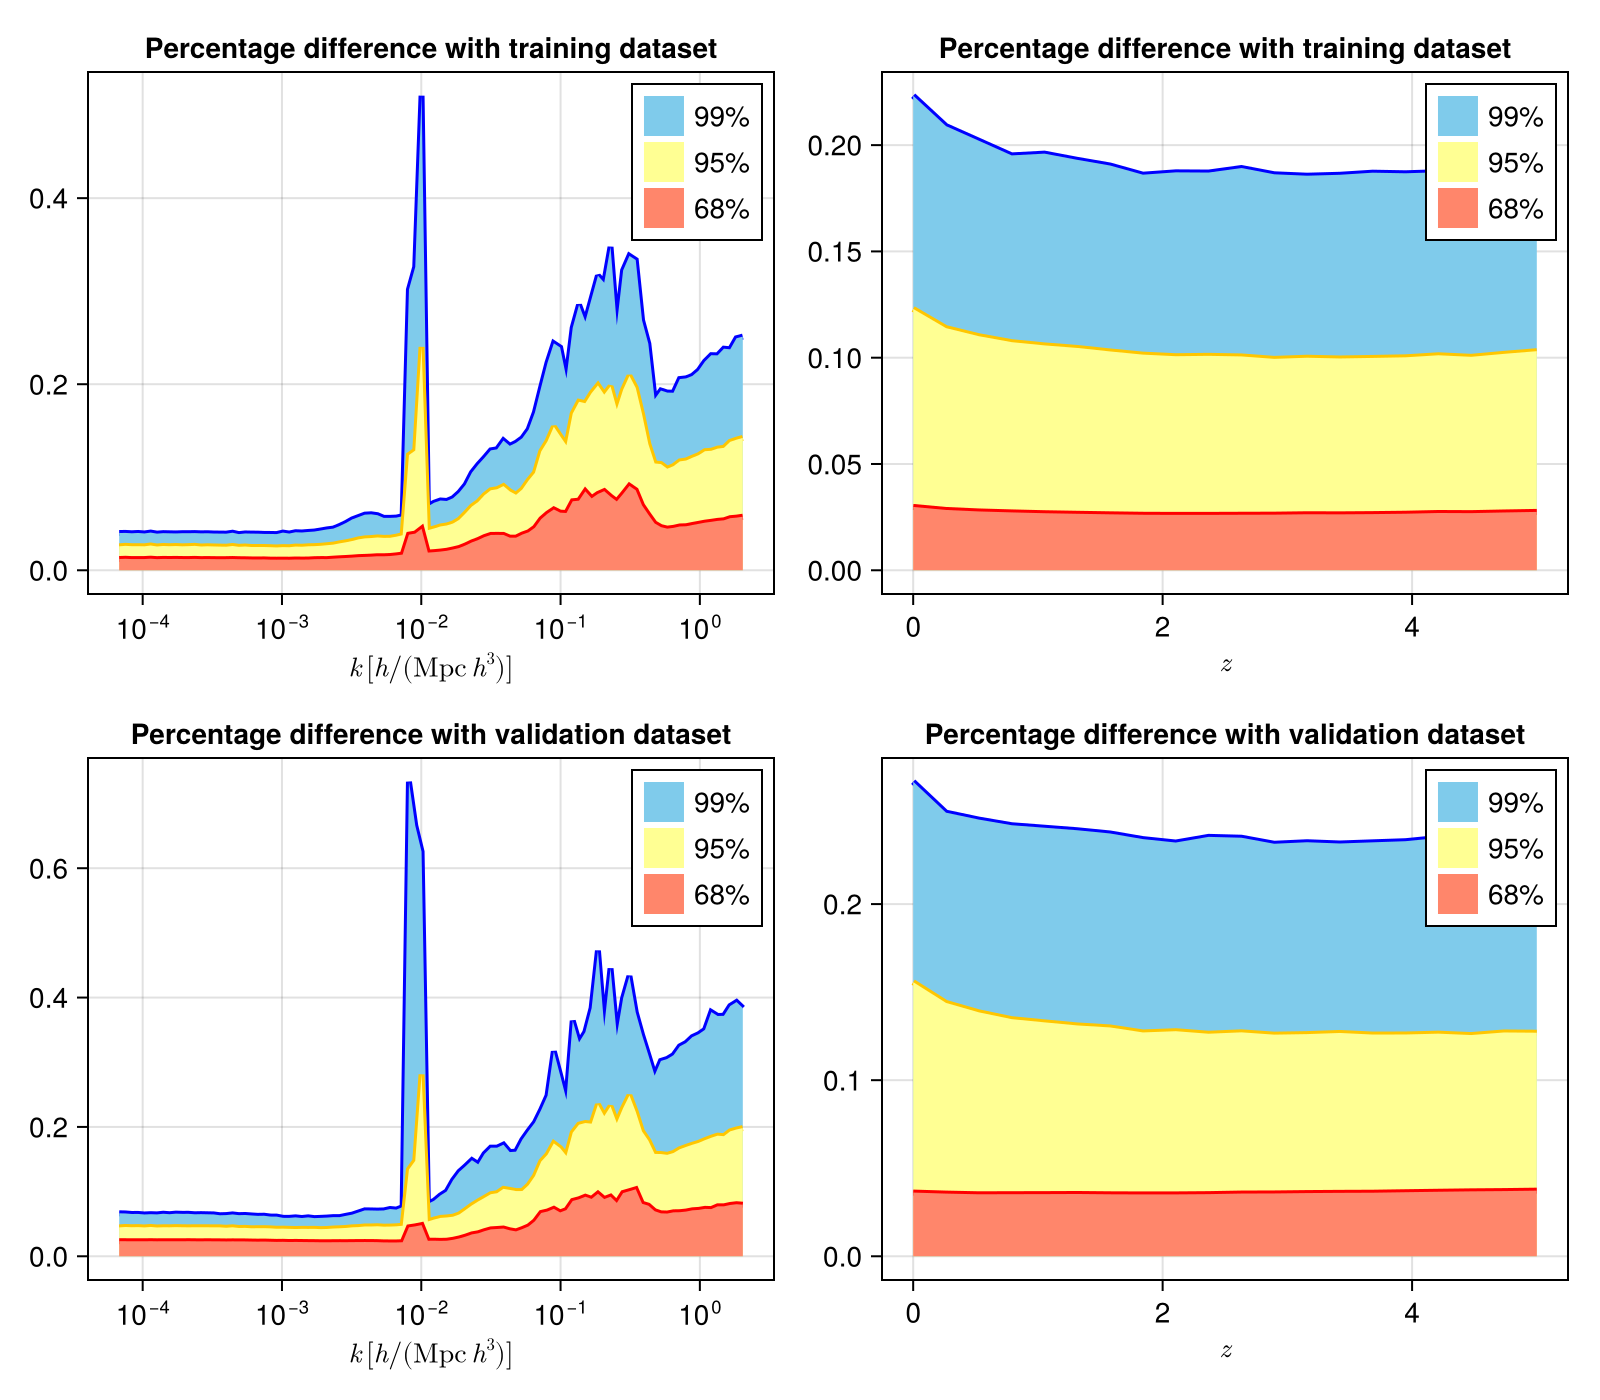

In [72]:
fig = Figure(size = (800, 700))

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

xax = [[kk,kk] [zz,zz]]
diffs = [[difk,difk_v] [difz,difz_v]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert(Int, (size(diffs[i,j])[1]/100)*99)
        l99 = lines!(ax, xax[i,j], diffs[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert(Int, (size(diffs[i,j])[1]/100)*95)
        l95 = lines!(ax, xax[i,j], diffs[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs[i,j][ind95,:], color="#FFFF93")

        ind68 = convert(Int, (size(diffs[i,j])[1]/100)*68)
        l68 = lines!(ax, xax[i,j], diffs[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Percentage difference with training dataset"
        else
            ax.title = "Percentage difference with validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(\mathrm{Mpc} \, h^3)]"
            ax.xscale = log10
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_pkz_nn+sr_$(cicli)-$(epoche)_$(div).pdf", fig)
return fig


## Stessa cosa ma con As e ns liberi

In [73]:
input2 = npzread("../files/train_in_asns_emul_" * string(nc) * ".npy")
output2 = npzread("../files/train_out_asns_emul_" * string(nc) * ".npy")
output2 = output2'

x2 = input2
y2 = output2

2000×2000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0213105   0.0203285   0.0231648   …  0.0262975   0.0254347   0.0237637
 0.0160204   0.0151905   0.017487       0.020269    0.0194597   0.0177715
 0.0121592   0.0114926   0.0133283      0.0156862   0.0149789   0.013426
 0.00940127  0.00887627  0.0103484      0.0123108   0.011712    0.0103382
 0.00742249  0.00700986  0.00820356     0.00983338  0.00933137  0.00813216
 0.0059796   0.00565319  0.00663465  …  0.00799592  0.00757463  0.00652944
 0.00490602  0.0046452   0.00546361     0.00661072  0.00625501  0.00534081
 0.0040906   0.00387985  0.00457138     0.00554755  0.00524479  0.00444069
 0.0034591   0.0032869   0.00387825     0.00471703  0.00445712  0.00374551
 0.00296127  0.00281905  0.00333017     0.00405746  0.00383247  0.00319889
 0.00256248  0.00244385  0.00288983  …  0.00352571  0.00332941  0.0027621
 0.00223842  0.00213854  0.00253096     0.00309113  0.00291862  0.00240799
 0.0019717   0.00188687  0.00223475     0.002731

In [74]:
# standardizzazione del trainig dataset (feature - min(features))/(max(features) - min(features))
min_in2 = minimum(x2, dims=2)
max_in2 = maximum(x2, dims=2)

min_out2 = minimum(y2, dims=2)
max_out2 = maximum(y2, dims=2)

x2 = (x2 .- min_in2) ./ (max_in2 .- min_in2)
y2 = (y2 .- min_out2) ./ (max_out2 .- min_out2)

2000×2000 Matrix{Float64}:
 0.18626   0.114835   0.321131  0.46073   …  0.548984  0.486229  0.364694
 0.182789  0.107295   0.316203  0.46815      0.569278  0.495657  0.342084
 0.178204  0.101313   0.313058  0.472852     0.585042  0.50346   0.324332
 0.173155  0.0964526  0.311524  0.476191     0.598235  0.510748  0.310039
 0.16798   0.0923438  0.311153  0.478857     0.609906  0.517887  0.298066
 0.162768  0.0887005  0.31141   0.480954  …  0.620304  0.524707  0.287537
 0.157012  0.085057   0.310844  0.480816     0.627315  0.529182  0.276966
 0.151501  0.0817321  0.310664  0.480668     0.63383   0.533599  0.267398
 0.146238  0.0786615  0.310722  0.480505     0.639878  0.537883  0.25863
 0.141228  0.0758065  0.310924  0.480323     0.645481  0.541982  0.250534
 0.136472  0.0731432  0.311211  0.480118  …  0.650651  0.545865  0.243029
 0.131971  0.0706563  0.311543  0.479892     0.655405  0.549512  0.236061
 0.127726  0.0683358  0.311895  0.479643     0.659755  0.552915  0.229592
 ⋮          

In [75]:
# carico lo stato allenato della rete

tstate2 = JLD2.load("../models/nn+sr_asns_$(cicli)-$(epoche)_$(div).jld2", "tstate")

# importo validation dataset

valid_in2 = npzread("../files/val_in_asns_emul_" * string(ncv) * ".npy")
valid_in2 = (valid_in2 .- minimum(valid_in2, dims=2)) ./ (maximum(valid_in2, dims=2) .- minimum(valid_in2, dims=2))
valid_out2 = npzread("../files/val_out_asns_emul_" * string(ncv) * ".npy")
val_out2 = valid_out2'

2000×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0234275   0.0223257   0.0246863   …  0.0260513   0.0210517   0.0227467
 0.0178274   0.0168739   0.0185685      0.0200533   0.0158493   0.017065
 0.0136648   0.0128881   0.0140855      0.0155128   0.0120701   0.0129316
 0.0106499   0.010034    0.0108759      0.0121783   0.0093766   0.0099864
 0.00846381  0.00797874  0.00857087     0.00973506  0.00744352  0.00787704
 0.00685653  0.00647331  0.0068903   …  0.00792419  0.00603112  0.00634098
 0.00565262  0.00534754  0.0056409      0.0065591   0.00497691  0.00519925
 0.00473307  0.00448788  0.00469316     0.00551095  0.00417311  0.00433279
 0.00401745  0.00381843  0.00396032     0.00469161  0.00354794  0.00366222
 0.00345083  0.00328773  0.00338359     0.00404035  0.00305286  0.00313391
 0.00299515  0.00286024  0.00292244  …  0.00351479  0.00265442  0.00271092
 0.00262351  0.00251094  0.00254839     0.00308482  0.00232913  0.00236736
 0.00231659  0.00222188  0.0022411      0.00272

In [76]:
# predizione con training dataset
dev_cpu = cpu_device()
pred_train_iniz2 = dev_cpu(Lux.apply(tstate2.model, x2, tstate2.parameters, tstate2.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_train_st2 = (pred_train_iniz2 .- minimum(pred_train_iniz2, dims=2)) ./ (maximum(pred_train_iniz2, dims=2) .- minimum(pred_train_iniz2, dims=2))

# de-standardizzo la predizione standardizzata
pred_train_st2 = pred_train_st2 .* (max_out2 - min_out2) .+ min_out2

# de-standrdizzo la predizione iniziale
pred_train2 = pred_train_iniz2 .* (max_out2 - min_out2) .+ min_out2

2000×2000 Matrix{Float64}:
 0.021306    0.0203308   0.0231703   …  0.0262937   0.0254346   0.0237731
 0.0160181   0.01519     0.0174895      0.0202693   0.0194593   0.0177824
 0.0121578   0.0114904   0.0133293      0.015685    0.0149787   0.0134331
 0.00940396  0.00887557  0.0103498      0.0123112   0.0117114   0.010345
 0.00742567  0.00700985  0.00820319     0.00983209  0.00933119  0.00813624
 0.00597846  0.00565433  0.00663457  …  0.0079954   0.00757406  0.00653368
 0.00490702  0.00464817  0.00546306     0.00661052  0.00625469  0.00534417
 0.00409008  0.00387888  0.00457121     0.00554781  0.00524384  0.00444265
 0.00345965  0.00328769  0.00387806     0.00471685  0.00445652  0.003747
 0.00296151  0.00282048  0.00333045     0.004058    0.0038318   0.00320043
 0.00256347  0.00244431  0.00288937  …  0.0035257   0.00332908  0.00276319
 0.00223912  0.00213892  0.00253103     0.00309116  0.00291817  0.00240889
 0.001973    0.00188675  0.00223475     0.00273165  0.00257871  0.00211773
 ⋮   

In [77]:
# predizione con validation dataset
pred_val_iniz2 = dev_cpu(Lux.apply(tstate2.model, valid_in2, tstate2.parameters, tstate2.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_val_st2 = (pred_val_iniz2 .- minimum(pred_val_iniz2, dims=2)) ./ (maximum(pred_val_iniz2, dims=2) .- minimum(pred_val_iniz2, dims=2))

# de-standardizzo la predizione standardizzata
pred_val_st2 = pred_val_st2 .* (max_out2 - min_out2) .+ min_out2

# de-standrdizzo la predizione iniziale
pred_val2 = pred_val_iniz2 .* (max_out2 - min_out2) .+ min_out2

2000×1000 Matrix{Float64}:
 0.0234275   0.0223156   0.0246806   …  0.0260495   0.0210591   0.0227398
 0.0178247   0.0168728   0.0185645      0.0200527   0.0158499   0.0170603
 0.0136626   0.0128878   0.0140796      0.0155106   0.0120706   0.0129276
 0.0106491   0.0100352   0.0108729      0.0121769   0.00937753  0.00998324
 0.00846328  0.0079795   0.00856721     0.00973367  0.00744374  0.00787475
 0.00685579  0.00647505  0.00689465  …  0.00792297  0.00603099  0.0063397
 0.00565299  0.00534916  0.00564253     0.00655823  0.00497673  0.00519858
 0.00473243  0.00448962  0.00469345     0.00551009  0.00417332  0.0043317
 0.00401753  0.00381948  0.00395928     0.00469089  0.00354831  0.00366134
 0.00345081  0.00328856  0.0033849      0.00403996  0.00305346  0.00313349
 0.00299539  0.00286086  0.00292265  …  0.00351406  0.00265498  0.00271073
 0.00262345  0.00251145  0.00254944     0.00308443  0.00232954  0.00236713
 0.00231657  0.00222177  0.00224007     0.0027282   0.00206075  0.00208426
 ⋮ 

## Plot residui rapporto

In [78]:
# preparo il plot delle differenze percentuali con il training dataset

diffk2 = zeros(Float64, nc*nz, nk)
diffz2 = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk2[:,i] = reshape(100*abs.(1 .- pred_train2[start:stop,:] ./ output2[start:stop,:]), nc*nz, 1)
end
diffk2 = sort(diffk2, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz2[:,i] = reshape(100*abs.(1 .- pred_train2[index,:] ./ output2[index,:]), nc*nk, 1)
end
diffz2 = sort(diffz2, dims=1)


200000×20 Matrix{Float64}:
 1.37919e-7  1.49454e-8  7.91074e-8  …  1.29289e-7  1.40154e-7  3.109e-7
 2.92085e-7  2.60086e-7  1.1739e-7      3.17723e-7  1.97435e-7  5.32542e-7
 4.78056e-7  3.80768e-7  3.35176e-7     5.23708e-7  7.96689e-7  6.14053e-7
 4.91345e-7  5.02801e-7  3.6645e-7      6.13428e-7  8.89727e-7  7.60366e-7
 6.88821e-7  1.00442e-6  8.3564e-7      6.22046e-7  1.15261e-6  8.37006e-7
 7.01616e-7  1.55128e-6  8.8013e-7   …  1.15744e-6  1.3477e-6   8.45711e-7
 1.04105e-6  1.58385e-6  1.28047e-6     1.34762e-6  2.20933e-6  9.92271e-7
 1.12794e-6  1.66373e-6  1.4122e-6      1.67122e-6  2.50197e-6  1.4585e-6
 1.57081e-6  1.9339e-6   1.55979e-6     2.20382e-6  3.31805e-6  1.66707e-6
 1.78993e-6  2.23171e-6  1.93299e-6     2.29479e-6  3.46903e-6  1.72626e-6
 1.86512e-6  2.37349e-6  1.95211e-6  …  2.35579e-6  3.50897e-6  1.92607e-6
 1.87833e-6  2.55197e-6  2.82283e-6     2.43992e-6  4.11326e-6  1.9949e-6
 2.42279e-6  2.8603e-6   3.02462e-6     2.76501e-6  4.12273e-6  2.11613e-6
 ⋮

In [79]:
# preparo il plot delle differenze percentuali con il validation dataset

diffk_v2 = zeros(Float64, ncv*nz, nk)
diffz_v2 = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk_v2[:,i] = reshape(100*abs.(1 .- pred_val2[start:stop,:] ./ val_out2[start:stop,:]), ncv*nz, 1)
end
diffk_v2 = sort(diffk_v2, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz_v2[:,i] = reshape(100*abs.(1 .- pred_val2[index,:] ./ val_out2[index,:]), ncv*nk, 1)
end
diffz_v2 = sort(diffz_v2, dims=1)

100000×20 Matrix{Float64}:
 1.02127e-7  5.5597e-7   3.34208e-7  …  3.07644e-8  1.4689e-8   6.39335e-7
 8.27261e-7  1.29417e-6  5.07085e-7     2.61196e-7  2.92828e-7  2.09706e-6
 1.66203e-6  1.34976e-6  7.7926e-7      4.49644e-7  3.29811e-7  3.42858e-6
 1.92245e-6  1.41614e-6  1.01174e-6     1.03239e-6  4.10261e-7  4.1758e-6
 2.06324e-6  1.81941e-6  1.59794e-6     1.07195e-6  4.37022e-7  4.42566e-6
 2.89896e-6  2.03604e-6  1.90914e-6  …  1.69438e-6  4.57e-7     5.77609e-6
 3.17943e-6  2.17587e-6  2.09307e-6     1.76531e-6  8.28624e-7  6.14801e-6
 3.66361e-6  3.46566e-6  2.22471e-6     1.7765e-6   1.24311e-6  7.09627e-6
 3.68069e-6  3.55542e-6  2.29209e-6     2.1201e-6   1.67719e-6  7.1268e-6
 4.44029e-6  4.87452e-6  2.38354e-6     2.24577e-6  2.50641e-6  7.19414e-6
 4.80295e-6  5.29554e-6  2.62498e-6  …  2.76542e-6  2.80595e-6  8.79838e-6
 6.07049e-6  6.65876e-6  3.46602e-6     3.1321e-6   3.03214e-6  9.16468e-6
 6.09014e-6  6.68604e-6  3.69488e-6     3.82158e-6  3.04827e-6  9.59717e-6


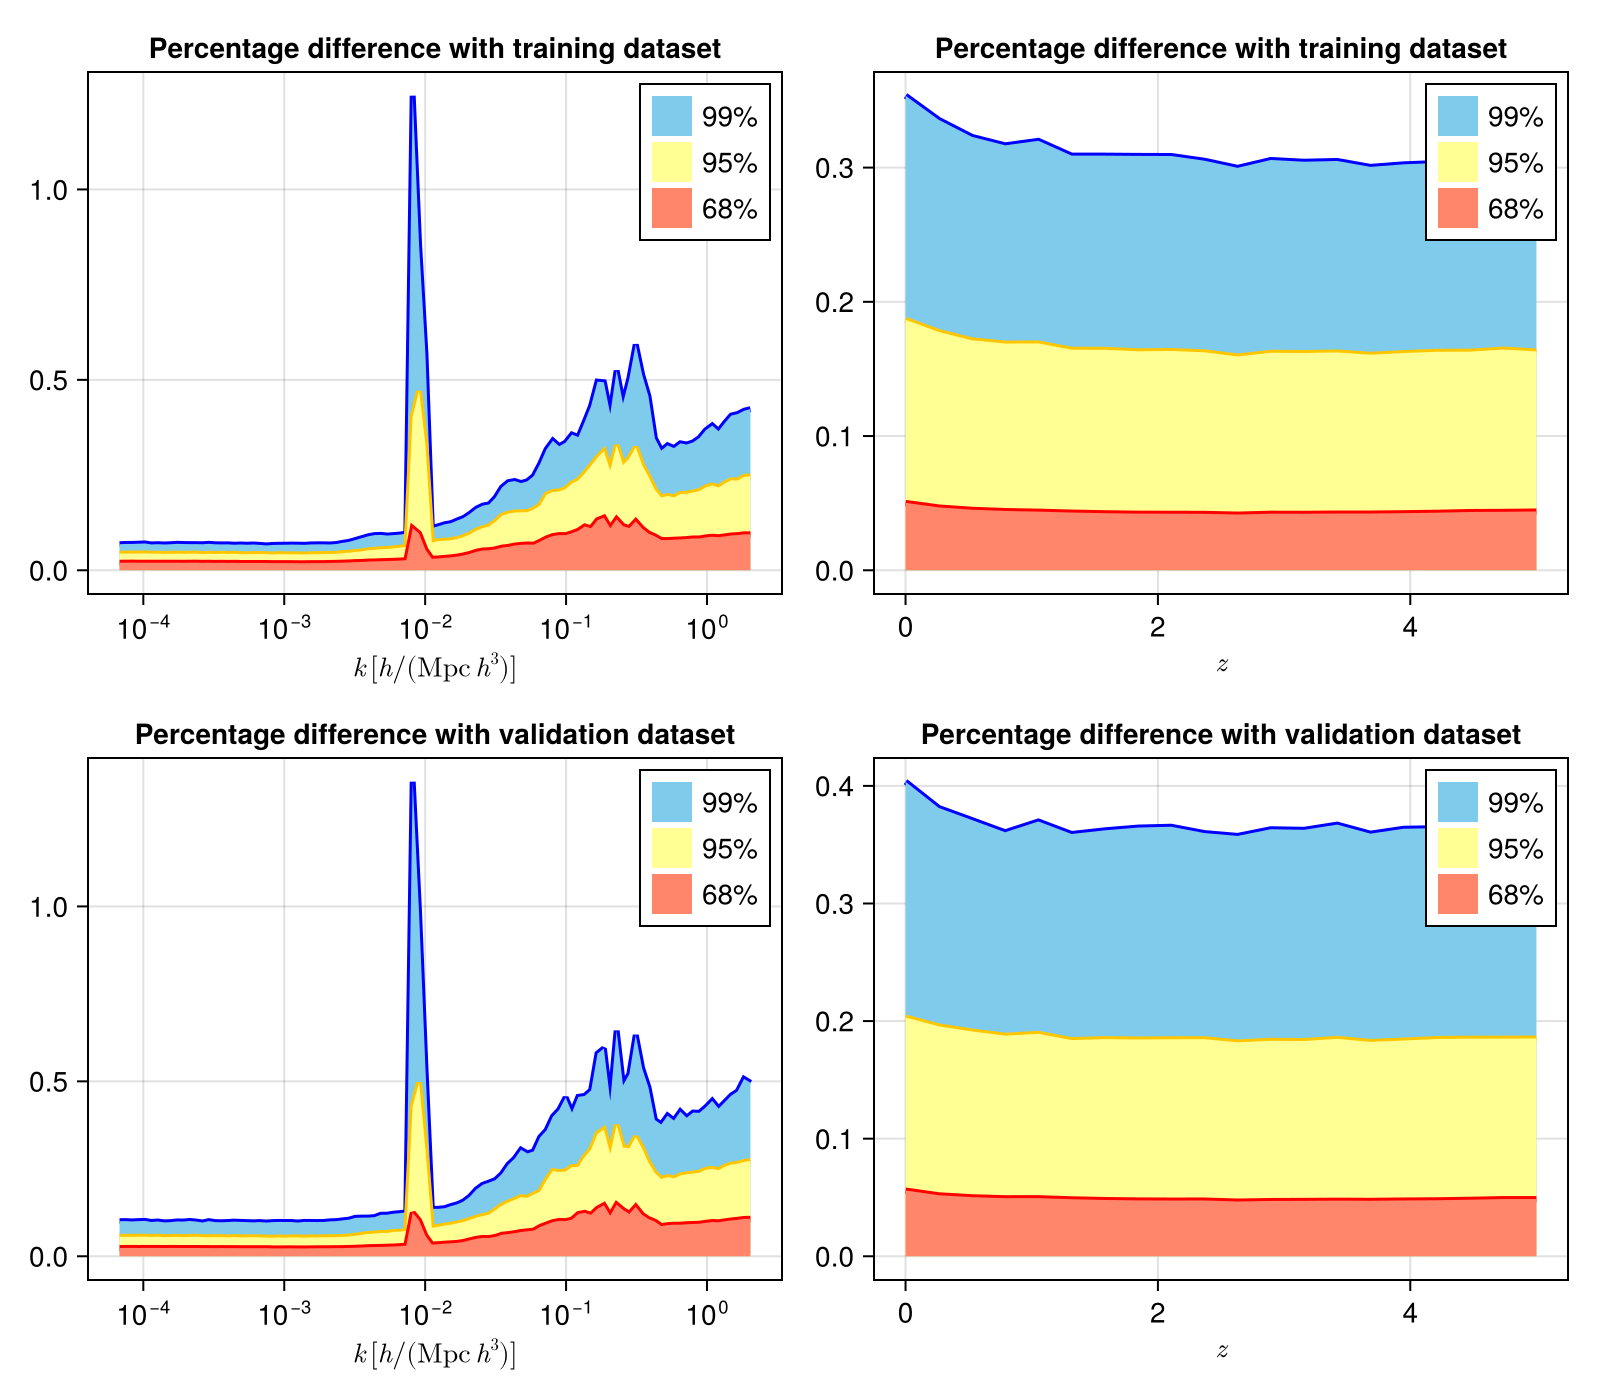

In [80]:
fig = Figure(size = (800, 700))

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

xax = [[kk,kk] [zz,zz]]
diffs2 = [[diffk2,diffk_v2] [diffz2,diffz_v2]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert(Int, (size(diffs2[i,j])[1]/100)*99)
        l99 = lines!(ax, xax[i,j], diffs2[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs2[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert(Int, (size(diffs2[i,j])[1]/100)*95)
        l95 = lines!(ax, xax[i,j], diffs2[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs2[i,j][ind95,:], color="#FFFF93")

        ind68 = convert(Int, (size(diffs2[i,j])[1]/100)*68)
        l68 = lines!(ax, xax[i,j], diffs2[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs2[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Percentage difference with training dataset"
        else
            ax.title = "Percentage difference with validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(\mathrm{Mpc} \, h^3)]"
            ax.xscale = log10
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_nn+sr_asns_$(cicli)-$(epoche)_$(div).pdf", fig)
return fig
